<a href="https://colab.research.google.com/github/Marcos-Sanson/Marcos-Sanson.github.io/blob/main/LAB01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



First of all the datasets are being loaded and visualized.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Device configuration (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST and FashionMNIST datasets
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

fashion_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
fashion_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
mnist_train_loader = DataLoader(dataset=mnist_train, batch_size=128, shuffle=True)
mnist_test_loader = DataLoader(dataset=mnist_test, batch_size=128, shuffle=False)

fashion_train_loader = DataLoader(dataset=fashion_train, batch_size=128, shuffle=True)
fashion_test_loader = DataLoader(dataset=fashion_test, batch_size=128, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 43854153.81it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 8112489.54it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13493132.16it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8589057.15it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 26421880/26421880 [00:05<00:00, 4584739.87it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 306083.56it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5614817.53it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 1078643.07it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Visualization of the data...

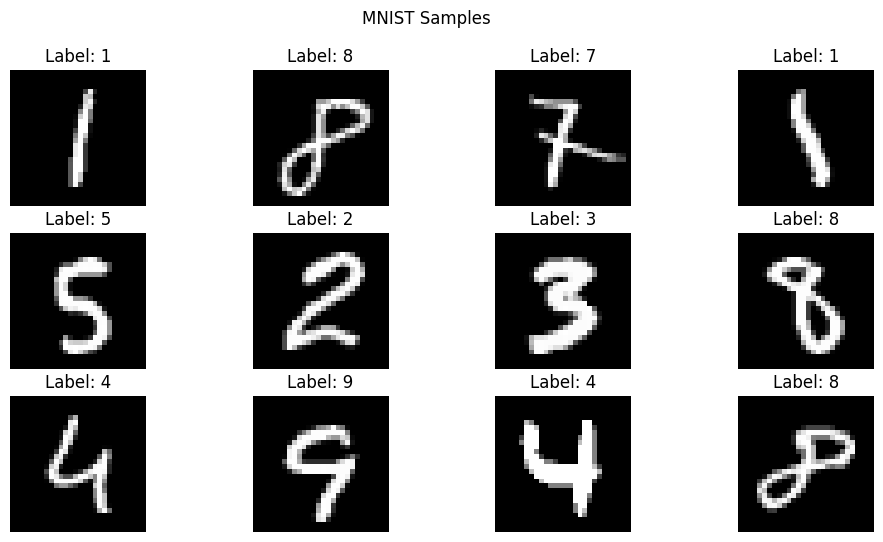

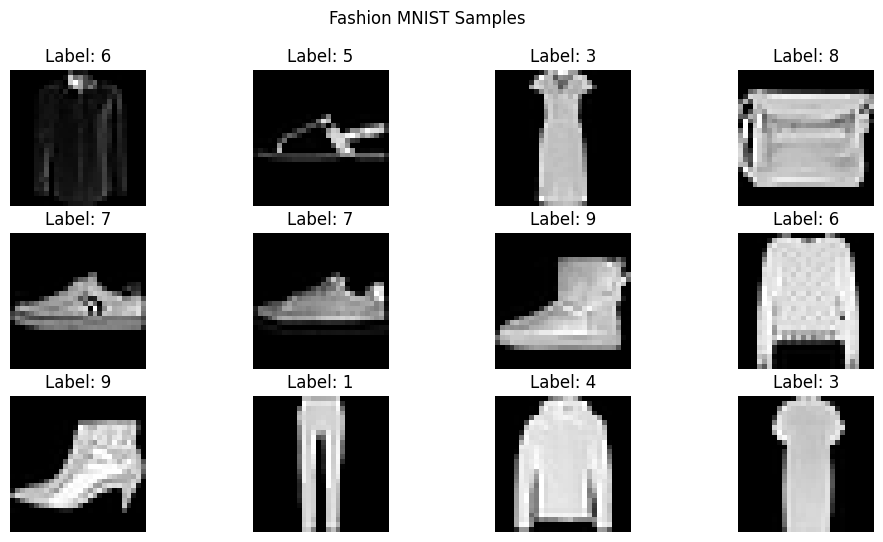

In [ ]:
import matplotlib.pyplot as plt

def visualize_samples(loader, title):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    plt.figure(figsize=(12, 6))
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Visualize MNIST samples
visualize_samples(mnist_train_loader, "MNIST Samples")

# Visualize Fashion MNIST samples
visualize_samples(fashion_train_loader, "Fashion MNIST Samples")

Now the encoder object is defined.


In [ ]:
# Encoder network
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7 * 7 * 64, 256),
            nn.ReLU()
        )

        # Shared layers for mean and log variance
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

Next up, the Decoder object is defined.

In [ ]:
# Decoder network
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 7 * 7 * 64),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        recon = self.decoder(z)
        return recon

Lastly, the latent spaces of both encoders have to be somehow combined. The product of experts is being applied.

In [ ]:
class MultiViewVAE(nn.Module):
    def __init__(self, latent_dim):
        super(MultiViewVAE, self).__init__()
        self.encoder_mnist = Encoder(latent_dim)
        self.encoder_fashion = Encoder(latent_dim)
        self.decoder_mnist = Decoder(latent_dim)
        self.decoder_fashion = Decoder(latent_dim)
    #forwarding function that uses an encoder for MNIST data and an encoder for Fashion MNIST data.
    def forward(self, x_mnist, x_fashion):
        x_mnist = (x_mnist + 1) / 2  # Normalize from [-1, 1] to [0, 1]
        x_fashion = (x_fashion + 1) / 2

        # Encode MNIST and Fashion MNIST to latent space
        z_mean_mnist, z_log_var_mnist = self.encoder_mnist(x_mnist)
        z_mean_fashion, z_log_var_fashion = self.encoder_fashion(x_fashion)

        # Combine the two views (latent spaces)
        combined_mean, combined_log_var = self.combine_latent_spaces(z_mean_mnist, z_log_var_mnist, z_mean_fashion, z_log_var_fashion)

        # Sample from the combined latent space using the reparameterization trick
        z_combined = self.reparameterize(combined_mean, combined_log_var)

        # Decode the combined latent space to reconstruct the images
        reconstructed_mnist = self.decoder_mnist(z_combined)
        reconstructed_fashion = self.decoder_fashion(z_combined)

        return reconstructed_mnist, reconstructed_fashion, combined_mean, combined_log_var

    def combine_latent_spaces(self, mean1, log_var1, mean2, log_var2):
        # Convert log variance to variance
        var1 = torch.exp(log_var1)
        var2 = torch.exp(log_var2)

        # Calculate the combined variance (product of experts)
        combined_var = 1 / (1 / var1 + 1 / var2)

        # Calculate the combined mean (product of experts)
        combined_mean = combined_var * (mean1 / var1 + mean2 / var2)

        # Convert combined variance to log variance
        combined_log_var = torch.log(combined_var)

        return combined_mean, combined_log_var

    #reparameterization trick to make backpropagation possible:
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

Now the ELBO Loss function is defined as the loss function used to train the model.

In [ ]:
# VAE loss function: Reconstruction loss + KL Divergence
def loss_function(reconstructed, original, z_mean, z_log_var):
    # Readjust the dimension of the original image s.t. the data points are closer in the output space.
    original = (original + 1) / 2

    original = original.clamp(0,1)
    # Reconstruction loss (BCE loss for images)
    recon_loss = nn.functional.binary_cross_entropy(reconstructed, original, reduction='sum')

    # KL Divergence loss
    kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())

    return recon_loss + kl_loss

Now a training function is defined to train the encoders

In [ ]:
def train_multi_view_vae(model, mnist_loader, fashion_loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        mnist_iter = iter(mnist_loader)
        fashion_iter = iter(fashion_loader)

        for i in range(len(mnist_loader)):
            x_mnist, _ = next(mnist_iter)
            x_fashion, _ = next(fashion_iter)

            x_mnist = x_mnist.to(device)
            x_fashion = x_fashion.to(device)

            optimizer.zero_grad()

            # Forward pass
            reconstructed_mnist, reconstructed_fashion, z_mean, z_log_var = model(x_mnist, x_fashion)

            # Compute loss for both views
            loss_mnist = loss_function(reconstructed_mnist, x_mnist, z_mean, z_log_var)
            loss_fashion = loss_function(reconstructed_fashion, x_fashion, z_mean, z_log_var)

            # Total loss is the sum of the two views' losses
            total_loss = loss_mnist + loss_fashion
            total_loss.backward()

            optimizer.step()

        print(f"Epoch {epoch + 1}, Loss: {total_loss.item() / len(mnist_loader.dataset)}")

Here the implementation is being tested:

In [ ]:
# Instantiate model and optimizer
latent_dim = 20
multi_view_vae = MultiViewVAE(latent_dim).to(device)

# Optimizing the parameters of the multi view VAE to ensure best results
optimizer = optim.Adam(multi_view_vae.parameters(), lr=1e-3)

# Train the Multi-View VAE
train_multi_view_vae(multi_view_vae, mnist_train_loader, fashion_train_loader, optimizer)

Epoch 1, Loss: 0.6724897135416666
Epoch 2, Loss: 0.611394140625
Epoch 3, Loss: 0.6146264322916667
Epoch 4, Loss: 0.6323697916666666
Epoch 5, Loss: 0.5843916666666666
Epoch 6, Loss: 0.6135106770833333
Epoch 7, Loss: 0.6132223307291667
Epoch 8, Loss: 0.579713671875
Epoch 9, Loss: 0.5993518229166667
Epoch 10, Loss: 0.580697265625


Method for visualizing the reconstruction of the decoder.

In [15]:
def visualize_reconstruction_mnist(model, mnist_loader, fashion_loader):
    model.eval()
    with torch.no_grad():
        x_mnist, _ = next(iter(mnist_loader))
        x_fashion, _ = next(iter(fashion_loader))
        x_mnist = x_mnist.to(device)
        x_fashion = x_fashion.to(device)

        reconstructed_mnist, reconstructed_fashion, _, _ = model(x_mnist, x_fashion)

        # Plot the first 5 MNIST images and their reconstructions
        for i in range(5):
            plt.subplot(2, 5, i + 1)
            plt.imshow(x_mnist[i].cpu().squeeze(), cmap="gray")
            plt.axis('off')

            plt.subplot(2, 5, i + 6)
            plt.imshow(reconstructed_mnist[i].cpu().squeeze(), cmap="gray")
            plt.axis('off')

In [16]:
def visualize_reconstruction_fmnist(model, mnist_loader, fashion_loader):
    model.eval()
    with torch.no_grad():
        x_mnist, _ = next(iter(mnist_loader))
        x_fashion, _ = next(iter(fashion_loader))
        x_mnist = x_mnist.to(device)
        x_fashion = x_fashion.to(device)

        reconstructed_mnist, reconstructed_fashion, _, _ = model(x_mnist, x_fashion)
        # Plot the first 5 FashionMNIST images and their reconstructions
        for i in range(5):
            plt.subplot(4, 5, i + 11)  # Third row for original FashionMNIST images
            plt.imshow(x_fashion[i].cpu().squeeze(), cmap="gray")
            plt.axis('off')

            plt.subplot(4, 5, i + 16)  # Fourth row for reconstructed FashionMNIST images
            plt.imshow(reconstructed_fashion[i].cpu().squeeze(), cmap="gray")
            plt.axis('off')

Visualzing the reconstruction using the visualization methods from above. The row above shows the original data and the row below the reconstructed images.

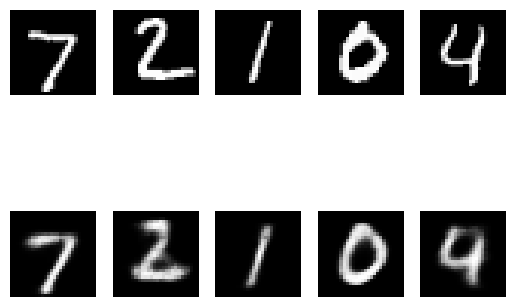

In [17]:
visualize_reconstruction_mnist(multi_view_vae,mnist_test_loader,fashion_test_loader)

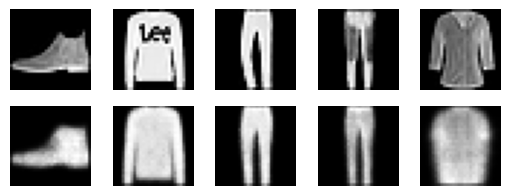

In [18]:
visualize_reconstruction_fmnist(multi_view_vae,mnist_test_loader,fashion_test_loader)